# Visualising intersections and overlaps between data sources

In [another notebook](extract_aggregated_data_from_harvest.ipynb) I extracted some summary information from the [complete harvest](complete_harvest.ipynb) of the People and Organisations data. This included information about how different data sources were aggregated into individual records. In this notebook we'll explore connections between data sources.

In [1]:
import itertools

import altair as alt
import pandas as pd
from pyvis.network import Network
from upsetplot import UpSet, from_memberships

## Overview of data sources
I've extracted details of the different data sources contributing to the People and Organisations zone and saved them in the [`peau_sources.csv`](peau_sources.csv) file. Let's have a little look at them.

In [2]:
df_sources = pd.read_csv("peau_sources.csv")

How many data sources are there?

In [3]:
df_sources.shape[0]

70

Let's display a list of sources and the number of records each source is linked to.

In [4]:
df_sources.sort_values("agency_id").style.hide().format(thousands=",").bar(
    subset=["total"], color="#aab6fe"
).set_properties(subset=["total"], **{"width": "400px"})

agency_id,agency_name,total
AU-AIAS,AIATSIS Aboriginal Biographical Index,"48,360"
AU-AMG,GeoScience Australia,260
AU-ANL:AD,Australia Dancing,325
AU-ANL:MA,Music Australia,255
AU-ANL:MA-DM,destra Media,410
AU-ANL:PEAU,National Library of Australia Party Infrastructure,"1,309,339"
AU-ANL:PO,National Library of Australia People and Organisations,5
AU-ANU,Australian National University,9
AU-ANU:ADBO,Australian Dictionary of Biography,"13,433"
AU-ANU:OA,Obituaries Australia,"8,115"


The two sources with the most number of records attached are 'AU-ANL:PEAU' and 'AuCNLKIN'. 'AU-ANL:PEAU' is the People and Organisations system itself, so it's included in every record. 'AuCNLKIN' refers to the National Bibliographic Database (otherwise known as Libraries Australia), another component in the NLA's digital infrastructure. The ANBD includes authority records for people and organisations which have been imported into the People and Organisations zone.

At the other end of the scale there's a large number of what appear to be test sources attached to small numbers of records. To clean things up a bit, we'll exclude sources that have 'OCLC', 'TO-DO', or 'PEAU' in them.

In [5]:
df_sources = df_sources.loc[
    ~df_sources["agency_id"].str.contains("OCLC|PEAU|TO-DO|AU-ANL:PO", regex=True)
]

## Connections between sources

The People and Organisations zone aggregates and disambiguates the biographical records it receives from these data sources. The idea is that all the information about a single person or organisation gets grouped together under a single 'identity'. This means that otherwise separate data sources meet in individual records, creating new connections between them. This is useful because it means if you have a record from the Australian Dictionary of Biography, for example, you can search in the People and Organisations zone for linked records from other data sources such as the Encyclopedia of Australian Science.

I've extracted the mix of data sources from each record in the People and Organisations zone and saved the data in the `peau_source_groups.csv` file. We can use this to explore how the data sources are connected. Each `source_group` in the data file includes a list of data sources separated by '|'. 

In [6]:
# Load the grouped sources
df_source_groups = pd.read_csv("peau_source_groups.csv").dropna()
df_source_groups

,source_group,number_of_sources,total
0,AuCNLKIN,1,941859
1,AU-SAUS,1,167827
2,AU-ANU:ADBO|AuCNLKIN,2,2144
3,AU-AIAS|AuCNLKIN,2,36574
4,AU-NUN:DAAO,1,12932
...,...,...,...
634,AU-NUWS|AU-VASD|AU-YORCID|AuCNLKIN,4,1
635,AU-ANU:ADBO|AU-NUN:DAAO|AU-VU|AU-VU:AWR|AU-VU:...,5,1
636,AU-ANL:MA|AU-ANU:ADBO|AU-ANU:OA|AU-SAUS|AuCNLKIN,5,1
637,AU-NMUS:CAN|AU-SAUS|AU-VPRO|AuCNLKIN|OCLC-BNF|...,9,1


The 70 data sources linked in 638 different combinations!

For the moment we won't worry about the numbers, we'll just look at the connections by generating a network graph. First we'll split all of the source groups into a list of lists.

In [7]:
# Turn the source groups into a list of lists
connections_list = (
    df_source_groups.loc[
        (df_source_groups["total"] > 0)
        & (
            ~df_source_groups["source_group"].str.contains(
                "OCLC|PEAU|TO-DO|AU-ANL:PO", regex=True
            )
        )
    ]
    .source_group.str.split("|")
    .to_list()
)

Then we'll convert this into a list of 'edges' – pairs of connected data sources.

In [8]:
# For each source group list, extract pairs of related sources
# These will be the edges in our network graph
related = []
for ls in connections_list:
    for i, l in enumerate(ls):
        for j in range(i + 1, len(ls)):
            related.append([l, ls[j]])

# Remove duplicates
related.sort()
edges = list(related for related, _ in itertools.groupby(related))

# Display and example of the output
edges[:5]

[['AU-AIAS', 'AU-ANL:AD'],
 ['AU-AIAS', 'AU-ANL:MA'],
 ['AU-AIAS', 'AU-ANL:MA-DM'],
 ['AU-AIAS', 'AU-ANU:ADBO'],
 ['AU-AIAS', 'AU-ANU:OA']]

The nodes in our network graph will be the data sources themselves. Here we create the graph.

In [9]:
# A couple of issues with PyVis:
# .set_values() doesn't work unless you include a configure value -- see: https://github.com/WestHealth/pyvis/issues/81
# The graph wouldn't settle unless I decresed the gravity below the default -2000
# set_values also seems to overide other config settings? Not sure about this but odd things happened.

net = Network(notebook=True, width="100%", height=600, directed=False)

Then we add the nodes and the edges.

In [10]:
# for agency_id, agency_name in agencies.items():
#    net.add_node(agency_id, title=agency_name, size=10)

for source in df_sources.itertuples():
    net.add_node(source.agency_id, title=source.agency_name, value=source.total)

for edge in edges:
    net.add_edge(edge[0], edge[1])

neighbor_map = net.get_adj_list()

# add neighbor data to node hover data
for node in net.nodes:
    # node['title'] += ' Connections:<br>' + '<br>'.join(neighbor_map[node['id']])
    node["value"] = len(neighbor_map[node["id"]])

Finally we style and display the network graph.

In [11]:
# net.toggle_physics(False)


net.set_options(
    """
var options = {
    "configure": {
            "enabled": true
    },
    "nodes": {
        "color": {
            "background": "#7986cb",
            "border": "#49599a",
            "highlight": {
                "background": "#aab6fe",
                "border": "#7986cb"
            }
        },
        "font": {
            "size": 20
        }
    },
    "edges": {
        "color": {
            "color": "#b0bec5",
            "highlight": "#808e95",
            "inherit": false
        }
    },
    "physics": {
        "barnesHut": {
          "gravitationalConstant": -12000
        },
        "minVelocity": 0.75
      }
}
"""
)

net.show("sources.html")

## Display intersections that include more than 50 records

As noted above, the 70 sources contributing data to the People & Organisations zone can be found in 638 unique combinations, or intersections, within individual records. If we try charting the number of records containing each unique combination, we see a very dramatic 'long tail' with most of these intersections involving only a very small number of records.

In [12]:
alt.Chart(df_source_groups.loc[df_source_groups["number_of_sources"] > 1]).mark_bar(
    size=1
).encode(
    x=alt.X("source_group:N", sort="-y", axis=alt.Axis(labels=False, ticks=False)),
    y=alt.Y("total:Q"),
    tooltip=["source_group", "total"],
).properties(
    width=alt.Step(2)
)

alt.Chart(...)

This is easier to see if we use a symlog scale for the y axis.

In [13]:
alt.Chart(df_source_groups.loc[df_source_groups["number_of_sources"] > 1]).mark_bar(
    size=1
).encode(
    x=alt.X("source_group:N", sort="-y", axis=alt.Axis(labels=False, ticks=False)),
    y=alt.Y("total:Q", scale=alt.Scale(type="symlog")),
    tooltip=["source_group", "total"],
).properties(
    width=alt.Step(2)
)

alt.Chart(...)

From the above chart we can see that more than half of the intersections appear in only one or two records.

So that we can focus on the most common intersections, we'll filter the source groups to show only intersections involving more than 50 records.

In [14]:
# We want to get intersections of greater than 50, and exclude sources that are not involved in those intersections
# First we'll create a list of sources that are involved in intersections > 50. We can then use this as a filter below.
sources = []
groups_gt_50 = (
    df_source_groups.loc[
        # Only groups gt 50
        (df_source_groups["total"] > 50)
        & (df_source_groups["number_of_sources"] > 1)
    ]["source_group"]
    .str.split("|")
    .to_list()
)
# Create a list of sources that are involved in intersections > 50
for group in groups_gt_50:
    sources.extend(group)
sources_gt_50 = list(set(sources))

In [15]:
# Get groups > 50 and single sources that are in the filtered list of sources
# Keeping in the single sources gives us the sources bar chart on the left edge of the upset chart.
df_source_groups_filtered = df_source_groups.loc[
    (df_source_groups["total"] > 50)
    & (
        (df_source_groups["source_group"].str.contains("|", regex=False))
        | (df_source_groups["source_group"].isin(sources_gt_50))
    )
].sort_values("total", ascending=False)

In [16]:
# Prepare data for upset chart
intersections = from_memberships(
    df_source_groups_filtered.source_group.str.split("|"),
    data=df_source_groups_filtered,
)

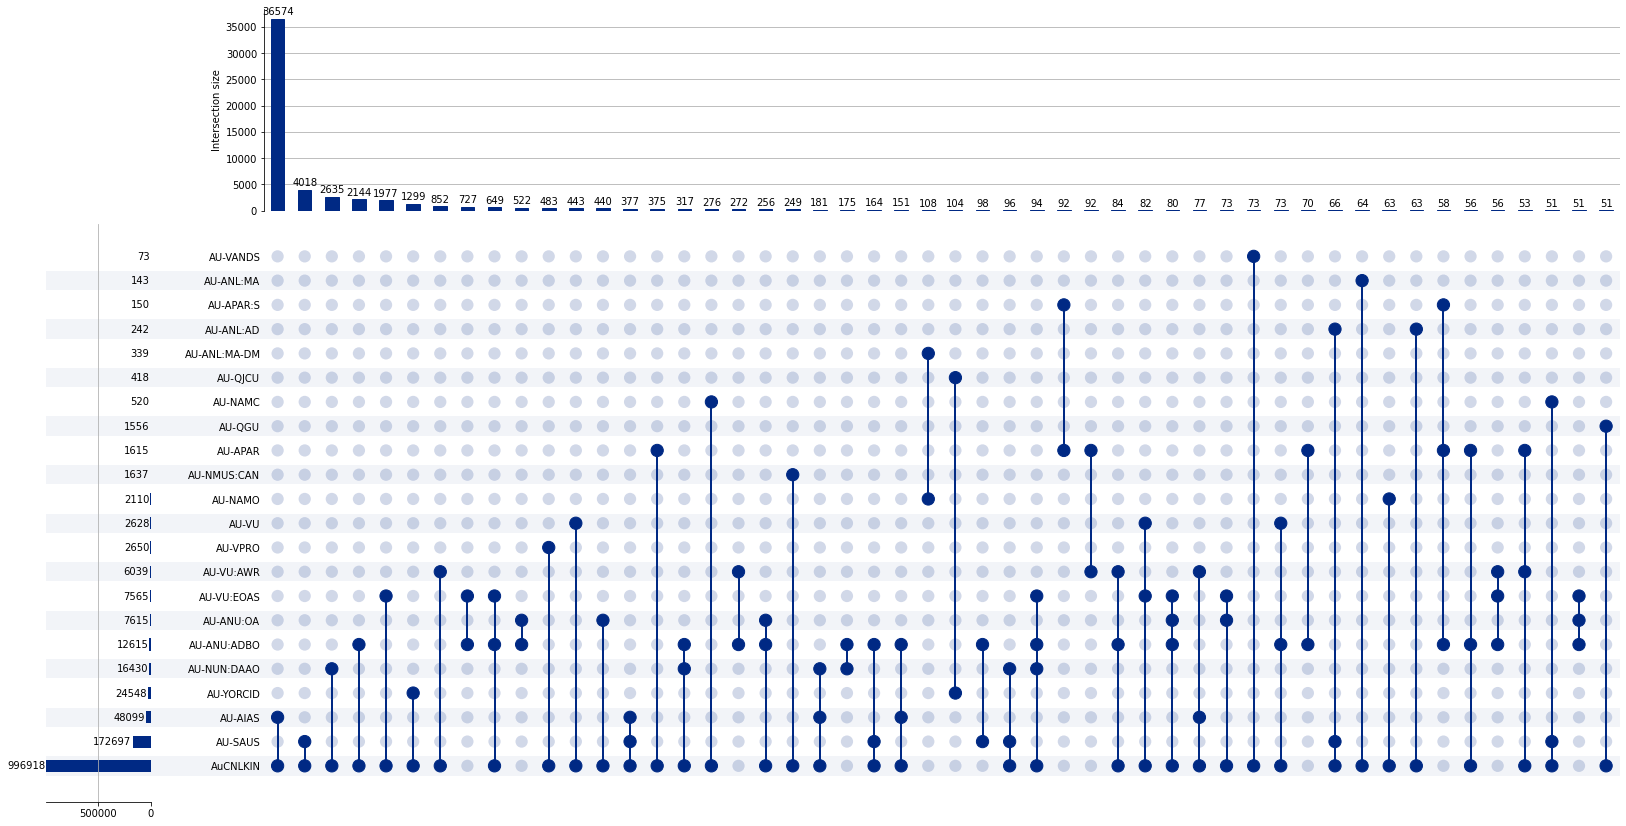

In [17]:
# Display the chart
chart = UpSet(
    intersections,
    sum_over="total",
    min_degree=2,
    show_counts=True,
    sort_by="cardinality",
    intersection_plot_elements=8,
    totals_plot_elements=4,
    facecolor="#002984",
    element_size=35,
)
# chart.style_subsets(present=["AU-ANU:ADBO"], edgecolor="red", linewidth=2)
chart

## Overlaps

The intersections data shows us unique combinations of sources, but it'd also be interesting to look at how often pairs of sources overlap across the full range of intersections.

The list of 'edges' we created above contains all the pairs of sources, so we'll start with that and calculate the number of times each pair appears in the identity records.

In [18]:
def count_overlaps(sources):
    """
    Find the number of records with a given pair of sources.
    The sources parameter is expected to be a list with two source labels.
    """
    overlap = df_source_groups.loc[
        (
            df_source_groups["source_group"].str.contains(
                rf"\b{sources[0]}(?:\||$)", regex=True
            )
        )
        & (
            df_source_groups["source_group"].str.contains(
                rf"\b{sources[1]}(?:\||$)", regex=True
            )
        )
    ]
    return overlap["total"].sum()

Using the function above we can find out how many records contain a given pair of sources, for example...

In [19]:
count_overlaps(["AU-VU", "AU-VU:EOAS"])

231

Now we'll find the total number of records for each pair in our list of edges.

In [20]:
overlaps = []
for edge in edges:
    overlap = count_overlaps(edge)
    # print(f'{"|".join(edge)}: {overlap}')
    overlaps.append({"sources": "|".join(edge), "total": overlap})

Let's convert to a dataframe and display the highest totals.

In [21]:
df_overlaps = pd.DataFrame(overlaps)

In [22]:
df_overlaps.sort_values("total", ascending=False)[:25].style.hide().format(
    thousands=","
).bar(subset=["total"], color="#aab6fe").set_properties(
    subset=["total"], **{"width": "400px"}
)

sources,total
AU-AIAS|AuCNLKIN,"37,573"
AU-SAUS|AuCNLKIN,"5,213"
AU-ANU:ADBO|AuCNLKIN,"4,591"
AU-NUN:DAAO|AuCNLKIN,"3,661"
AU-VU:EOAS|AuCNLKIN,"3,392"
AU-ANU:ADBO|AU-VU:EOAS,"1,854"
AU-YORCID|AuCNLKIN,"1,502"
AU-VU:AWR|AuCNLKIN,"1,478"
AU-ANU:OA|AuCNLKIN,"1,160"
AU-ANU:ADBO|AU-ANU:OA,"1,125"


Not surprisingly, 'AuCNLKIN' (Libraries Australia) appears in most of the pairs. To see the overlaps between other sources more easily, lets exclude the pairs that include Libraries Australia.

In [23]:
df_overlaps.loc[~df_overlaps["sources"].str.contains("AuCNLKIN")].sort_values(
    "total", ascending=False
)[:25].style.hide().format(thousands=",").bar(
    subset=["total"], color="#aab6fe"
).set_properties(
    subset=["total"], **{"width": "400px"}
)

sources,total
AU-ANU:ADBO|AU-VU:EOAS,"1,854"
AU-ANU:ADBO|AU-ANU:OA,"1,125"
AU-ANU:ADBO|AU-NUN:DAAO,784
AU-ANU:ADBO|AU-VU:AWR,617
AU-ANU:ADBO|AU-SAUS,439
AU-AIAS|AU-SAUS,428
AU-ANU:OA|AU-VU:EOAS,282
AU-ANU:ADBO|AU-APAR,265
AU-APAR|AU-APAR:S,237
AU-ANU:ADBO|AU-VU,236


In [24]:
# Prepare data for upset chart
overlaps = from_memberships(
    df_overlaps.loc[~df_overlaps["sources"].str.contains("AuCNLKIN")]
    .sort_values("total", ascending=False)[:50]
    .sources.str.split("|"),
    data=df_overlaps.loc[~df_overlaps["sources"].str.contains("AuCNLKIN")].sort_values(
        "total", ascending=False
    )[:50],
)

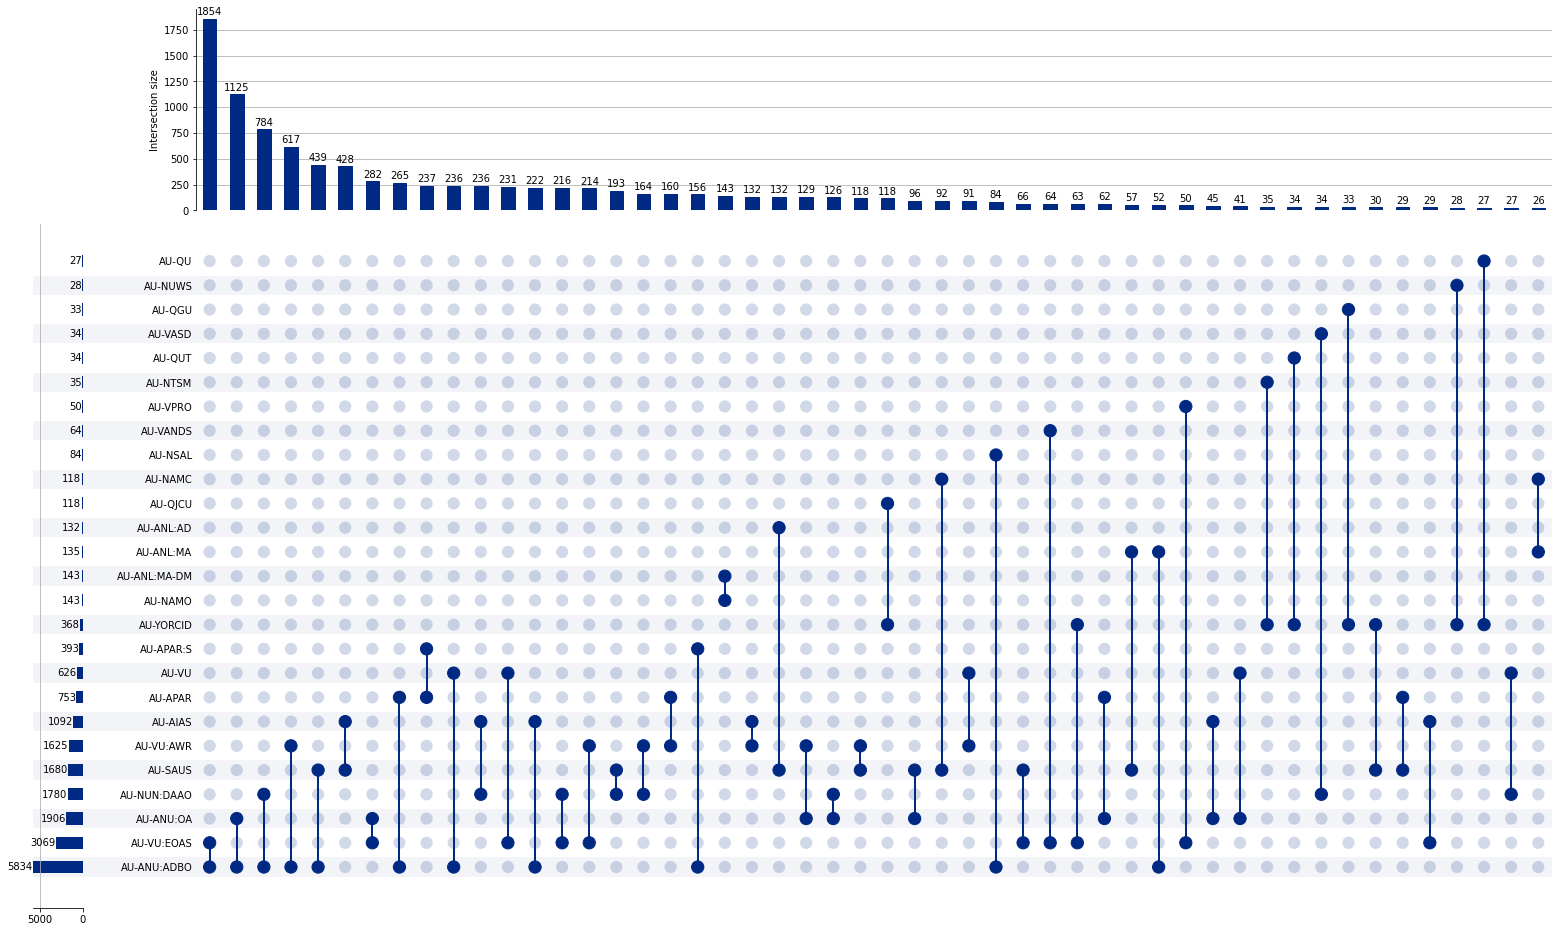

In [25]:
chart = UpSet(
    overlaps,
    sum_over="total",
    show_counts=True,
    sort_by="cardinality",
    intersection_plot_elements=8,
    totals_plot_elements=2,
    facecolor="#002984",
    element_size=35,
)
# chart.style_subsets(present=["AU-ANU:ADBO"], edgecolor="red", linewidth=2)
chart

----

Created by [Tim Sherratt](http://timsherratt.org/) for the [GLAM Workbench](https://glam-workbench.net/).

The development of this notebook was supported by the [Australian Cultural Data Engine](https://www.acd-engine.org/).